# Imbalanced data set

Imbalanced data refers to a classification problem where the classes are not represented equally. The PaySim dataset is highly unbalanced and the dataset will have to be either oversampled (SMOTE) or the class weights have to be changed in order for the model to make accurate predictions.

***Oversampling the minority class***

Oversampling is more computationally expensive but no data is lost compared to undersampling. In this case the data is 50% genuine and 50% fraud transactions.
Random Over-Sampling randomly adds more minority observations by replication. Although no information is lost, the model can overfit.

On the other hand, SMOTE creates "synthetic" observations of new data points of the minority class.

# Confusion Matrix

- **True Positive** - **TP** [ 0 ] [ 0 ] - How many genuine transactions were correctly predicted as genuine.

- **False Positive** - **FP** [ 0 ] [ 1 ] - How many genuine transactions were predicted as fraud. This shows how many genuine transactions have been rejected, because the model thought that it was fraud.

- **False Negative** - **FN** [ 1 ] [ 0 ] - How many fraud transactions were predicted as genuine. **This is the most important metric!** It indicates that fraud has occurred and has not been detected.

- **True Negative** - **TN** [ 1 ] [ 1 ] - How many fraud transactions were correctly predicted as fraud.

# Metrics

In traditional binary classification, one must minimize the loss function and maximize the metrics such as F1-score, accuracy, etc.

Unfortunately **accuracy** will not work for this fraud detection dataset, because there there are 99% genuine transactions and less than 1% fraudulent transactions. This impies that the accuracy will at least be 99% correct. Hence the **accuracy paradox** occurs. 

For fraud detection, the **AUC** of a classifier can be interpreted as being the probability that a randomly chosen fraud case is predicted a higher score than a randomly chosen legitimate case. Therefore, a higher AUC indicates superior classification performance. When dealing with highly imbalanced data as is the case with fraud detection, **AUC** (and **ROC** curves) may be too optimistic and the **Area under the Precision-Recall Curve (AUPRC)** gives a more informative picture of a classifier's performance.

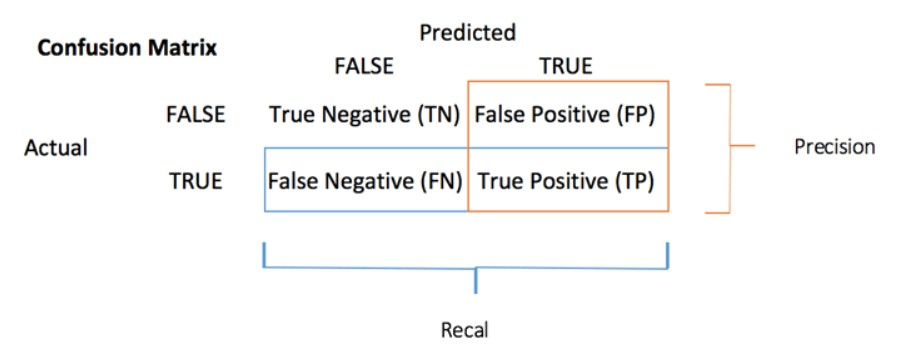

However the most important metric is the **% of fraud detected** by the model. This metrics focuses on how the number of **False Negative** transactions. **False Negatives** are crucial because this indicates that fraudulent transactions are thought to be genuine. This leads to banks losing money.
**False Positives** (genuine transactions that are thought to be fraudulent) are less crucial - the bank has to contact the customer to verify them or the other way around - customer calls the bank to verify that they are doing the "suspicious" transaction.
<br><br> 
The metric is calculated the following way:
<br><br>
$Total fraud = FN + TN$
<br><br>
$\% Fraud = \frac{TN}{Total fraud}$
<br><br>
$\% Missed = 1 - \% Fraud$



In [1]:
# Import XGBoost
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

# Import Random Forest
from sklearn.ensemble import RandomForestClassifier

# Import GaussianNB
from sklearn.naive_bayes import GaussianNB, MultinomialNB

# Logistic Regression
from sklearn.linear_model import LogisticRegression

# K-Nearest Neighbours
from sklearn.neighbors import KNeighborsClassifier

# RNN
import csv
import keras
import tensorflow as tf
from keras import backend as K

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, average_precision_score, plot_precision_recall_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.utils import class_weight
from google.colab import drive
from imblearn.over_sampling import SMOTE
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Help functions

In [2]:
def showReport(testY, predictions):
  # Get confusion matrix results
  results = confusion_matrix(testY, predictions)
  # True Positive
  TP = results[0][0]
  # False Positive
  FP = results[0][1]
  # False Negative
  FN = results[1][0]
  # True Negative
  TN = results[1][1]

  # Calculate the total fraud detected - True Negative / total fraud (which is False Negative + True Negative)
  fraudDetected = TN / (FN + TN)

  print("TP = ", TP, "\t\t\tFP = ", FP, "\n")
  print("FN = ", FN, "\t\t\tTN = ", TN, "\n")
  print("% of fraud detected:\t", round(fraudDetected, 2), "(", fraudDetected ,")\n")
  print("% of fraud missed:\t", round((1 - fraudDetected), 2), "(", (1 - fraudDetected),")\n")
  print("Average Precision-Recall score:\t", average_precision_score(testY, predictions))


In [3]:
# Display all plots
def showPlots(model, testX, testY):
  # Plot the confusion matrix results
  class_names = ['Genuine', 'Fraud']
  plot_confusion_matrix(model, testX, testY, display_labels=class_names, values_format='')
  # Plot the Precision-Recall curve
  plot_precision_recall_curve(model, testX, testY)

# Data Preparation
For the data visualisation and cleaning, please refer to [Data_Visualisation.ipynb](https://github.com/nickninov/ML-Fraud-Detection/blob/main/Data_Visualisation.ipynb).<br>
**isFraud** indicates if the transaction is genuine or fraudulent.
- isFraud = 0 means that the transaction is genuine.
- isFraud = 1 means that the transaction is fraudulent.

In [5]:
drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
path = "/content/drive/My Drive/Colab Notebooks/Project/Data/"
data = pd.read_csv(path+"Encoded PaySim.csv")
data = data.drop(['Unnamed: 0'], axis = 1)

In [7]:
X = data.drop(['isFraud'], axis = 1)
Y = data['isFraud']

In [8]:
# Details about the dataset
pos, neg = np.bincount(Y)
total = neg + pos
print("Total transactions:\t\t", total,"\n")
print("Genuine transactions:\t\t", pos, "(", round((pos * 100 / total), 2), "%)\n")
print("Fraudulent transactions:\t", neg, "(", round((neg * 100 / total), 2), "%)\n")

Total transactions:		 2770409 

Genuine transactions:		 2762196 ( 99.7 %)

Fraudulent transactions:	 8213 ( 0.3 %)



In [9]:
data.head(10)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,errorBalanceOrig,errorBalanceDest,HourOfDay,DayOfWeek
0,1,181.00,181.00,0.0,-1.0,-1.00,1,0.00,181.00,1,1
1,1,181.00,181.00,0.0,21182.0,0.00,1,0.00,21363.00,1,1
2,1,229133.94,15325.00,0.0,5083.0,51513.44,0,213808.94,182703.50,1,1
3,1,215310.30,705.00,0.0,22425.0,0.00,0,214605.30,237735.30,1,1
4,1,311685.89,10835.00,0.0,6267.0,2719172.89,0,300850.89,-2401220.00,1,1
5,1,110414.71,26845.41,0.0,288800.0,2415.16,0,83569.30,396799.55,1,1
6,1,56953.90,1942.02,0.0,70253.0,64106.18,0,55011.88,63100.72,1,1
7,1,5346.89,0.00,0.0,652637.0,6453430.91,0,5346.89,-5795447.02,1,1
8,1,23261.30,20411.53,0.0,25742.0,0.00,0,2849.77,49003.30,1,1
9,1,62610.80,79114.00,16503.2,517.0,8383.29,0,0.00,54744.51,1,1


# Traditional Machine Learning





## Random Forests

Random Forests is a supervised machine learning algorithm that is based on ensemble learning. This algorithm combines multiple decision trees, which forms a forest. Initially every tree has the same weight towards the end result. The final result is processed by checking which answer has highest votes. Random Forests can be used for both regression and classification tasks.

Random Forests have a time complexity of **O(t u n log(n))** where:
- **t** - number of trees
- **u** - number of features considered for splitting

### Class Weights
In this example the Random Forest classifier takes into consideration that the dataset is highly unbalanced. The weights are set by calling `class_weight: "balanced"`. Fraud transactions have a higher weight than genuine transactions.

In [ ]:
# Split the data into 70% training and 30% testing, make sure data split is consistent (random_state)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.3, random_state = 5)

genuine, fraud = class_weight.compute_class_weight('balanced', np.unique(trainY), trainY)

# Display the weights for every class, when class_weight = 'balanced'
print("Weight for a genuine transaction:\t", genuine)
print("Weight for a fraud transaction:\t\t", fraud)

Weight for a genuine transaction:	 0.5014648682446043
Weight for a fraud transaction:		 171.16381288614298


In [ ]:
forest = RandomForestClassifier(bootstrap = True, max_depth = 100, max_features = 2,
                                min_samples_leaf = 3, min_samples_split = 10, n_estimators = 200, 
                                random_state = 10, verbose = 1, class_weight = "balanced")
# Train model with train data
forest.fit(trainX, trainY)

# Test model's predictions with test data
predictions = forest.predict(testX)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 15.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   14.2s finished


In [ ]:
showReport(testY, predictions)

TP =  828575 			FP =  0 

FN =  6 			TN =  2542 

% of fraud detected:	 1.0 ( 0.9976452119309263 )

% of fraud missed:	 0.0 ( 0.0023547880690737433 )

Average Precision-Recall score:	 0.9976524310789946


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   14.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   14.7s finished


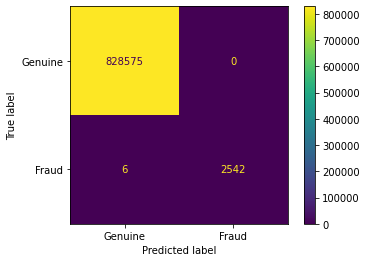

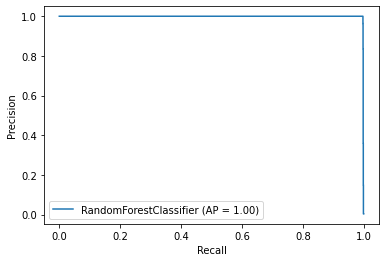

In [ ]:
showPlots(forest, testX, testY)

### SMOTE - Synthetic Minority Oversampling Technique


In [ ]:
oversample = SMOTE()
overX, overY = oversample.fit_resample(X, Y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print("Normal: ", Counter(Y))
print("SMOTE: ", Counter(overY))

Normal:  Counter({0: 2762196, 1: 8213})
SMOTE:  Counter({1: 2762196, 0: 2762196})


In [ ]:
# Split the data into 80% training and 20% testing, make sure data split is consistent (random_state)
trainX, testX, trainY, testY = train_test_split(overX, overY, test_size = 0.2, random_state = 5)

forest = RandomForestClassifier(bootstrap = True, max_depth = 100, max_features = 2,
                                min_samples_leaf = 3, min_samples_split = 10, n_estimators = 200, 
                                random_state = 10, verbose = 1)
# Train model with train data
forest.fit(trainX, trainY)

# Test model's predictions with test data
predictions = forest.predict(testX)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 47.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   24.6s finished


In [ ]:
showReport(testY, predictions)

TP =  552366 			FP =  3 

FN =  44 			TN =  552466 

% of fraud detected:	 1.0 ( 0.999920363432336 )

% of fraud missed:	 0.0 ( 7.963656766396543e-05 )

Average Precision-Recall score:	 0.999954757061117


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   24.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   25.4s finished


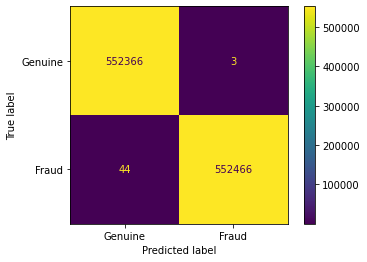

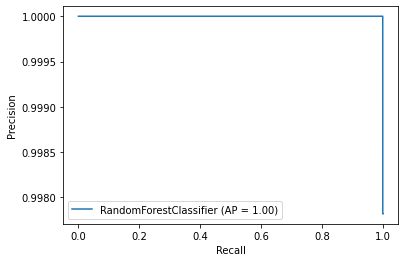

In [ ]:
showPlots(forest, testX, testY)

## XGBoost - Extreme Gradient Boosting

Boosting is used to in supervised learning. It is an ensemble algorithm that combines weak learners to form a strong learner and increase the accuracy of the model. Rules help identify a specific class. If a class is identified on an individual learner then the prediction is flawed. Multiple rules are used before determining the class of the final output. 

In **Gradient Boosting**, the base learners are generated sequentially that the current base learner is more effective from its predecessor. The loss function is optimized of the previous learner. **Extreme Gradient Boosting** has high speed and performance. It is used for regression and classification problems. **XGBoost** is used as a starting point to make accurate predictions for other models. This algorithm supports:
- **Parallelization** - the  algorithm uses maximum available computational power
- **Cache optimization** - keeps its calculations in the cache and fetches it fast to perform calculations
- **Out of memory computation** - **XGBoost** can work with data that is more than the available space.
- **Regularization** - prevents the model of overfitting
- **Missing values** - takes care of missing values in a dataset

**XGBoost** has a time complexity of **O(t d x log(n))** where:
- **t** - number of trees
- **d** - height of trees
- **x** - is the number of non-missing entries in the training data

A new sample takes **O(t d)** time.

### Class weights

In this example XGBoost takes into consideration the weights to make its calculations by setting the `scale_pos_weight` hyperparameter with the specified weight.

In [ ]:
# Split the data into 70% training and 30% testing, make sure data split is consistent (random_state)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.3, random_state = 5)

In [ ]:
# Calculate the weights
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())

xgb = XGBClassifier(n_estimators = 100, learning_rate = 0.01, subsample = 0.3, max_depth = 5, colsample_bytree = 0.5, min_child_weight = 3, scale_pos_weight = weights)

# Train model with train data
xgb.fit(trainX, trainY)

# Test model's predictions with test data
predictions = xgb.predict(testX)

In [ ]:
showReport(testY, predictions)

TP =  828292 			FP =  283 

FN =  7 			TN =  2541 

% of fraud detected:	 1.0 ( 0.9972527472527473 )

% of fraud missed:	 0.0 ( 0.0027472527472527375 )

Average Precision-Recall score:	 0.8973240139715768


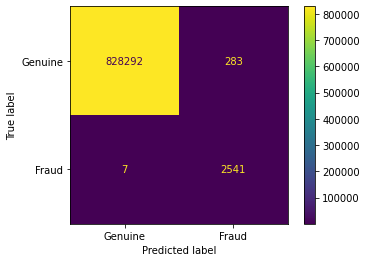

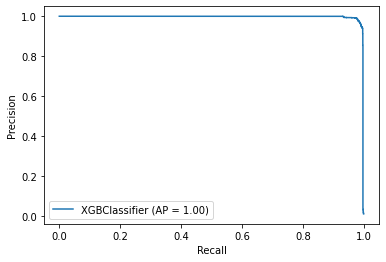

In [ ]:
showPlots(xgb, testX, testY)

### SMOTE - Synthetic Minority Oversampling Technique

In [ ]:
oversample = SMOTE()
overX, overY = oversample.fit_resample(X, Y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print("Normal: ", Counter(Y))
print("SMOTE: ", Counter(overY))

Normal:  Counter({0: 2762196, 1: 8213})
SMOTE:  Counter({1: 2762196, 0: 2762196})


In [ ]:
# Split the data into 70% training and 30% testing, make sure data split is consistent (random_state)
trainX, testX, trainY, testY = train_test_split(overX, overY, test_size = 0.3, random_state = 5)

In [ ]:
weights = (overY == 0).sum() / (1.0 * (overY == 1).sum()) 
xgb = XGBClassifier(n_estimators = 100, learning_rate = 0.01, subsample = 0.3, max_depth = 5, colsample_bytree = 0.5, min_child_weight = 3)

# Train model with train data
xgb.fit(trainX, trainY)

# Test model's predictions with test data
predictions = xgb.predict(testX)

In [ ]:
showReport(testY, predictions)

TP =  828723 			FP =  40 

FN =  3309 			TN =  825246 

% of fraud detected:	 1.0 ( 0.9960063001249163 )

% of fraud missed:	 0.0 ( 0.003993699875083689 )

Average Precision-Recall score:	 0.997954624970451


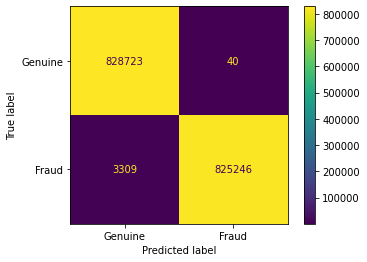

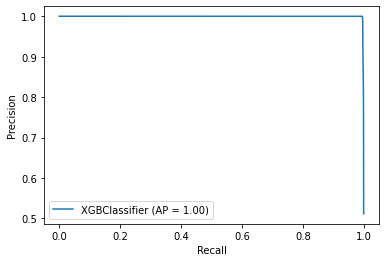

In [ ]:
showPlots(xgb, testX, testY)

## Logistic Regression

This algorithm is similar to Linear Regression but Logistic Regression classifies binary dependent variables, rather than predicting continuous data. Instead of fitting a line to the data, Logistic Regression fits a **S** shaped logistic function.
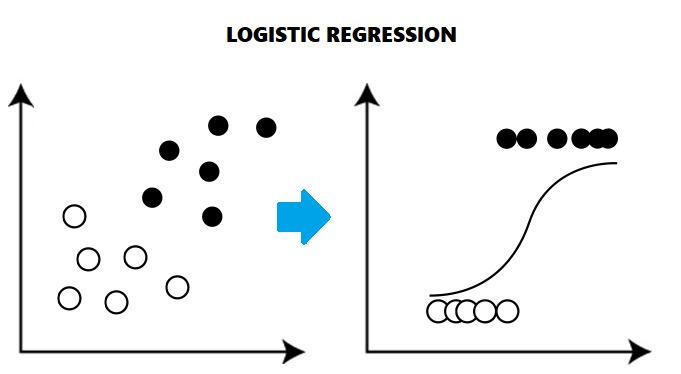

The time complexity is **O(n d)** where:
- **n** - number of training examples
- **d** - number of dimensions of the data


### Class Weights

In this example the Logistic Regression takes into consideration that the dataset is highly unbalanced. The weights are set by calling `class_weight: "balanced"`. Fraud transactions have a higher weight than genuine transactions.

In [ ]:
# Split the data into 70% training and 30% testing, make sure data split is consistent (random_state)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.3, random_state = 5)

In [ ]:
logistic = LogisticRegression(C = 3, penalty = 'l1', solver = 'liblinear', class_weight = 'balanced')

genuine, fraud = class_weight.compute_class_weight('balanced', np.unique(trainY), trainY)

# Display the weights for every class, when class_weight = 'balanced'
print("Weight for a genuine transaction:\t", genuine)
print("Weight for a fraud transaction:\t\t", fraud)

Weight for a genuine transaction:	 0.5014648682446043
Weight for a fraud transaction:		 171.16381288614298


In [ ]:
logistic.fit(trainX, trainY)

predictions = logistic.predict(testX)

In [ ]:
showReport(testY, predictions)

TP =  781150 			FP =  47425 

FN =  245 			TN =  2303 

% of fraud detected:	 0.9 ( 0.9038461538461539 )

% of fraud missed:	 0.1 ( 0.09615384615384615 )

Average Precision-Recall score:	 0.042153647957073145


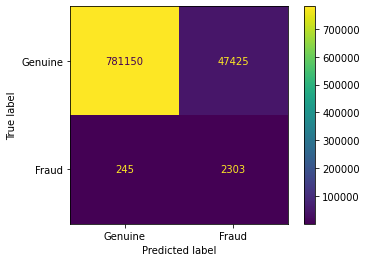

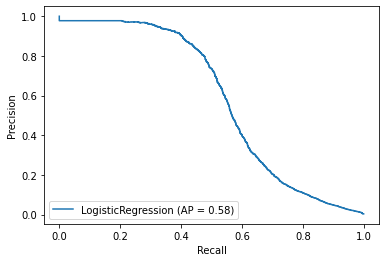

In [ ]:
showPlots(logistic, testX, testY)

### SMOTE - Synthetic Minority Oversampling Technique

In [ ]:
oversample = SMOTE()
overX, overY = oversample.fit_resample(X, Y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print("Normal: ", Counter(Y))
print("SMOTE: ", Counter(overY))

Normal:  Counter({0: 2762196, 1: 8213})
SMOTE:  Counter({1: 2762196, 0: 2762196})


In [ ]:
# Split the data into 70% training and 30% testing, make sure data split is consistent (random_state)
trainX, testX, trainY, testY = train_test_split(overX, overY, test_size = 0.3, random_state = 5)

In [ ]:
logistic = LogisticRegression(C = 3, penalty = 'l1', solver = 'liblinear')

logistic.fit(trainX, trainY)

predictions = logistic.predict(testX)

In [ ]:
showReport(testY, predictions)

TP =  781691 			FP =  47072 

FN =  67661 			TN =  760894 

% of fraud detected:	 0.92 ( 0.9183385532644182 )

% of fraud missed:	 0.08 ( 0.08166144673558184 )

Average Precision-Recall score:	 0.9056618608066571


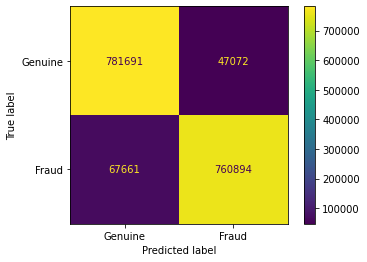

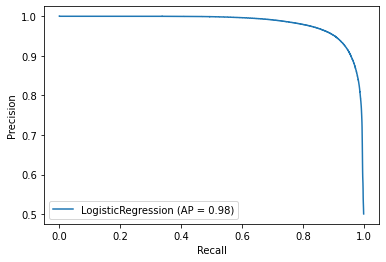

In [ ]:
showPlots(logistic, testX, testY)

## Naive Bayes Classifier

Naive Bayes works on the principles of conditional probability as given by Bayes' Theorem. It calculates the conditional probability of the occurrence of an event based on prior knowledge of conditions that might be related to the event.

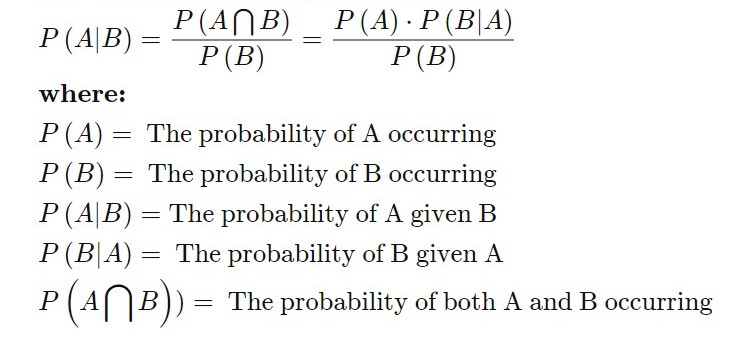

The Gaussian Naive Bayes is a variant of Naive Bayes that follows the Gaussian normal distribution and supports continuous data. Out of the different Naive Bayes types, Gaussian Naive Bayes is used for Fraud Detection. 

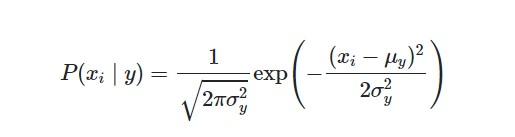


The time complexity is **O(n d)** where:
- **n** - number of training examples
- **d** - number of dimensions of the data

### Normal

In [ ]:
# Split the data into 70% training and 30% testing, make sure data split is consistent (random_state)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.3, random_state = 5)

In [ ]:
gnb = GaussianNB()
gnb.fit(trainX, trainY)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
predictions = gnb.predict(testX)

In [ ]:
showReport(testY, predictions)

TP =  820137 			FP =  8438 

FN =  1531 			TN =  1017 

% of fraud detected:	 0.4 ( 0.39913657770800626 )

% of fraud missed:	 0.6 ( 0.6008634222919937 )

Average Precision-Recall score:	 0.04477406897669674


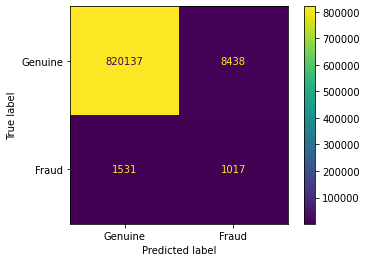

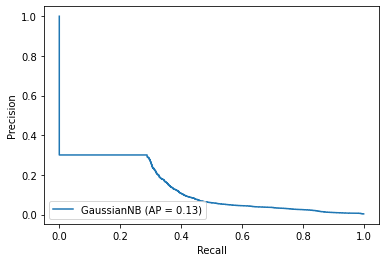

In [ ]:
showPlots(gnb, testX, testY)

### SMOTE - Synthetic Minority Oversampling Technique

In [ ]:
oversample = SMOTE()
overX, overY = oversample.fit_resample(X, Y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print("Normal: ", Counter(Y))
print("SMOTE: ", Counter(overY))

Normal:  Counter({0: 2762196, 1: 8213})
SMOTE:  Counter({1: 2762196, 0: 2762196})


In [ ]:
# Split the data into 70% training and 30% testing, make sure data split is consistent (random_state)
trainX, testX, trainY, testY = train_test_split(overX, overY, test_size = 0.3, random_state = 5)

In [ ]:
gnb = GaussianNB()
gnb.fit(trainX, trainY)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
predictions = gnb.predict(testX)

In [ ]:
showReport(testY, predictions)

TP =  813832 			FP =  14931 

FN =  444747 			TN =  383808 

% of fraud detected:	 0.46 ( 0.4632257363723591 )

% of fraud missed:	 0.54 ( 0.5367742636276409 )

Average Precision-Recall score:	 0.7142334434104556


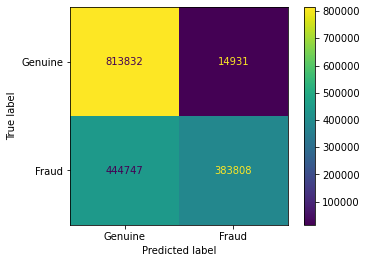

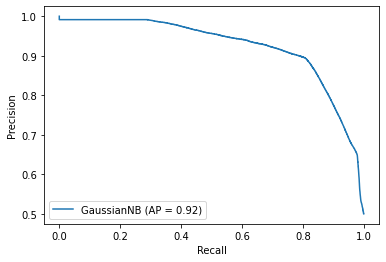

In [ ]:
showPlots(gnb, testX, testY)

## K-Nearest Neighbour
K-Nearest Neighbours is a simple supervised machine learning algorithm that is used to solve classification and regression problems. This algorithm identifies the k nearest neighbours of new unlabelled data. **K** is the number of nearest neighbours that will be considered when deciding the data's class. A good practice is to choose an **odd K** number so the when deciding the class of the unlabelled data, one class has more votes than the other by one.

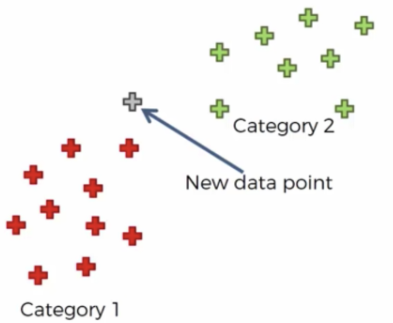

This algorithm is very easy to use and does not require a lot of maths. However, the cons are that it is memory intensive, new predictions take longer time and there is no real pre-processing. The bigger the **K** parameter is, the more time it will take to compute the label.
The time complexity is **O(k n d)** where:
- **k** - number of neighbours
- **n** - number of training examples
- **d** - number of dimensions of the data



In [10]:
scaler = StandardScaler()

### Normal

In [ ]:
X_scaled = scaler.fit_transform(X)

In [ ]:
# Split the data into 70% training and 30% testing, make sure data split is consistent (random_state)
trainX, testX, trainY, testY = train_test_split(X_scaled, Y, test_size = 0.3, random_state = 5)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance', p=2)
knn.fit(trainX, trainY)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')

In [ ]:
predictions = knn.predict(testX)

In [ ]:
showReport(testY, predictions)

TP =  828462 			FP =  113 

FN =  799 			TN =  1749 

% of fraud detected:	 0.69 ( 0.6864207221350078 )

% of fraud missed:	 0.31 ( 0.3135792778649922 )

Average Precision-Recall score:	 0.6457249605257486


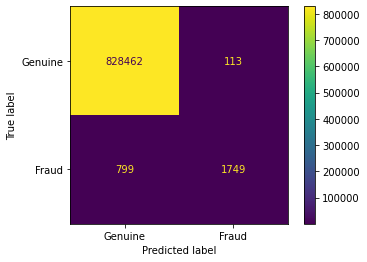

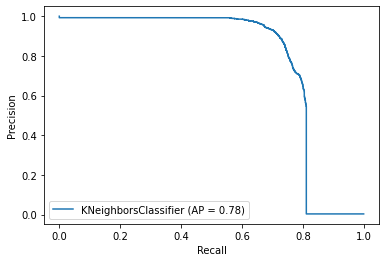

In [ ]:
showPlots(knn, testX, testY)

### SMOTE - Synthetic Minority Oversampling Technique

In [11]:
oversample = SMOTE()
overX, overY = oversample.fit_resample(X, Y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [12]:
X_scaled = scaler.fit_transform(overX)

In [13]:
print("Normal: ", Counter(Y))
print("SMOTE: ", Counter(overY))

Normal:  Counter({0: 2762196, 1: 8213})
SMOTE:  Counter({1: 2762196, 0: 2762196})


In [14]:
# Split the data into 70% training and 30% testing, make sure data split is consistent (random_state)
trainX, testX, trainY, testY = train_test_split(X_scaled, overY, test_size = 0.3, random_state = 5)

In [15]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance', p=2)
knn.fit(trainX, trainY)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')

In [16]:
predictions = knn.predict(testX)

In [17]:
showReport(testY, predictions)

TP =  827138 			FP =  1625 

FN =  679 			TN =  827876 

% of fraud detected:	 1.0 ( 0.9991805009926921 )

% of fraud missed:	 0.0 ( 0.0008194990073079333 )

Average Precision-Recall score:	 0.9976327953861513


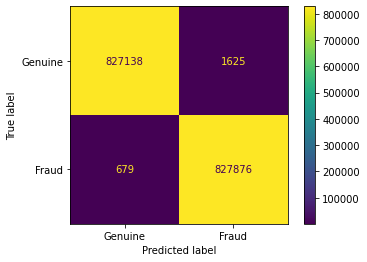

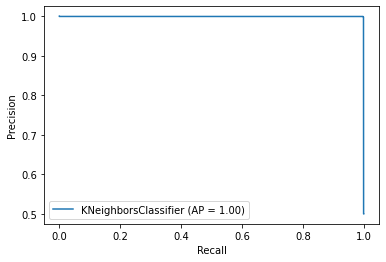

In [18]:
showPlots(knn, testX, testY)

# Deep Learning - Recurrent Neural Networks
In the following examples, the training has already been done. The models are stored in different files. The results are shown for both scaled and unscaled data to compare differences.
<br><br>
In the following examples, the training data is scaled down by using **Normalization** - **MinMaxScaler**. The data's values are between 0 and 1. The SMOTE technique has been used to create more fraudulent transactions.
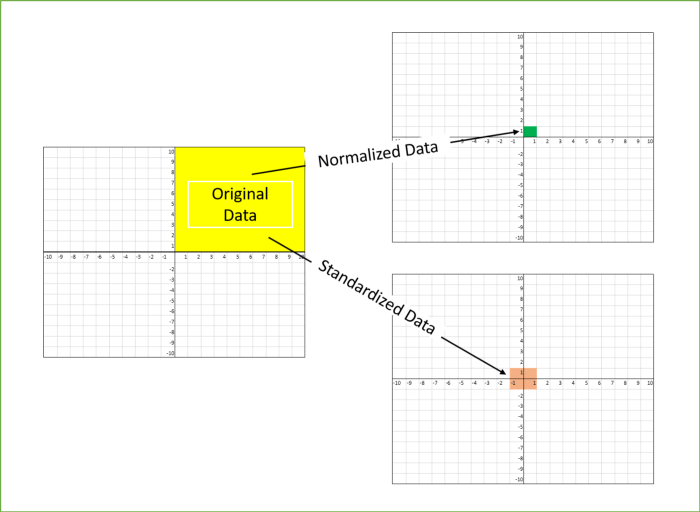
<br>In this case the Gradient Descent **convergest much faster** rather than without scaling the data.
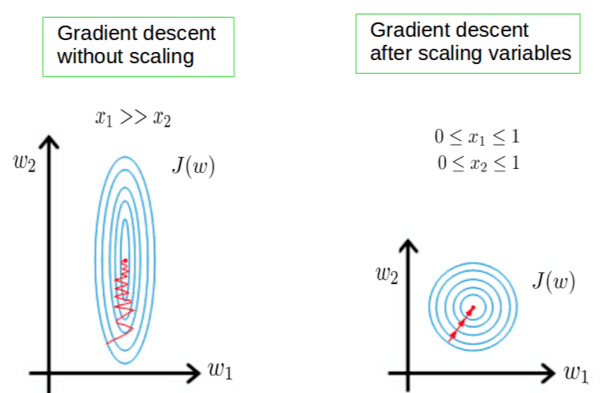

In [ ]:
scaler = MinMaxScaler()

### Model 1
This is the initial model that was proposed by an [article](https://www.preprints.org/manuscript/202006.0368/v1). The data **X** has been made from a 2D numpy array to a 3D tensor, so it can be fed to the model. 2 epochs were completed. The batch size is 64. 

In [ ]:
# Balance the data by using SMOTE
oversample = SMOTE()
overX, overY = oversample.fit_resample(X, Y)

# Scale data
X_scaled = scaler.fit_transform(overX)

# Reshape X form 2d to 3d
newX = np.array(X_scaled)
newX = newX.reshape(newX.shape[0], newX.shape[1], 1)

# Split the data into 80% training and 20% testing, make sure data split is consistent (random_state)
trainX, testX, trainY, testY = train_test_split(newX, overY, test_size = 0.2, random_state = 5)

path = "/content/drive/My Drive/Colab Notebooks/Project/Data/Models/Scaled/Suggestion/Model 1/"

model = keras.models.load_model(path + "RNN_epochs_2_batch_64_SimpleRNN.h5")
lossHistory = np.genfromtxt(path + "loss_epochs_2.csv", delimiter=',')

print(model.summary())

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 10, 128)           16640     
_________________________________________________________________
dropout (Dropout)            (None, 10, 128)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 10, 64)            12352     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 10, 32)            3104      
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 32)            0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 10, 16)            7

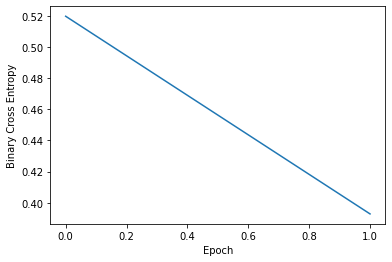

In [ ]:
plt.plot(lossHistory)
plt.xlabel("Epoch")
plt.ylabel("Binary Cross Entropy")
plt.show()

In [ ]:
predictions = model.predict_classes(x= testX, batch_size=64)
predictions = predictions[:, 0, 0]
showReport(testY, predictions)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP =  519657 			FP =  32712 

FN =  276340 			TN =  276170 

% of fraud detected:	 0.5 ( 0.49984615663064924 )

% of fraud missed:	 0.5 ( 0.5001538433693508 )

Average Precision-Recall score:	 0.6970190246996255


### Model 2
This is the exact same design as **Model 1** but **LSTM** has been used instead of **SimpleRNN**.

In [ ]:
# Balance the data by using SMOTE
oversample = SMOTE()
overX, overY = oversample.fit_resample(X, Y)

# Scale data
X_scaled = scaler.fit_transform(overX)

# Reshape X form 2d to 3d
newX = np.array(X_scaled)
newX = newX.reshape(newX.shape[0], newX.shape[1], 1)

# Split the data into 80% training and 20% testing, make sure data split is consistent (random_state)
trainX, testX, trainY, testY = train_test_split(newX, overY, test_size = 0.2, random_state = 5)

path = "/content/drive/My Drive/Colab Notebooks/Project/Data/Models/Scaled/Suggestion/Model 2/"

model = keras.models.load_model(path + "RNN_epochs_2_batch_64_LSTM.h5")
lossHistory = np.genfromtxt(path + "loss_epochs_2.csv", delimiter=',')

print(model.summary())

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 128)           66560     
_________________________________________________________________
dropout (Dropout)            (None, 10, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 64)            49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 32)            12416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 32)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 16)            3

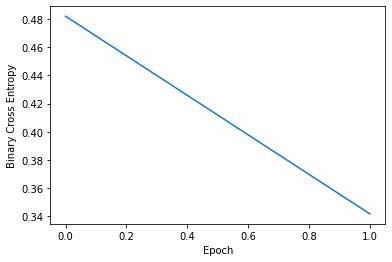

In [ ]:
plt.plot(lossHistory)
plt.xlabel("Epoch")
plt.ylabel("Binary Cross Entropy")
plt.show()

In [ ]:
predictions = model.predict_classes(x= testX, batch_size=64)
predictions = predictions[:, 0, 0]
showReport(testY, predictions)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP =  520097 			FP =  32272 

FN =  280096 			TN =  272414 

% of fraud detected:	 0.49 ( 0.49304808962733704 )

% of fraud missed:	 0.51 ( 0.506951910372663 )

Average Precision-Recall score:	 0.6943332906993416


### Model 3
This model uses the structure from **Model 1** but has went through 20 epochs.

In [ ]:
# Balance the data by using SMOTE
oversample = SMOTE()
overX, overY = oversample.fit_resample(X, Y)

# Scale data
X_scaled = scaler.fit_transform(overX)

# Reshape X form 2d to 3d
newX = np.array(X_scaled)
newX = newX.reshape(newX.shape[0], newX.shape[1], 1)

# Split the data into 80% training and 20% testing, make sure data split is consistent (random_state)
trainX, testX, trainY, testY = train_test_split(newX, overY, test_size = 0.2, random_state = 5)

path = "/content/drive/My Drive/Colab Notebooks/Project/Data/Models/Scaled/More Epochs/Model 1/"

model = keras.models.load_model(path + "RNN_epochs_20_batch_64_SimpleRNN.h5")
lossHistory = np.genfromtxt(path + "loss.csv", delimiter=',')

print(model.summary())

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 10, 128)           16640     
_________________________________________________________________
dropout (Dropout)            (None, 10, 128)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 10, 64)            12352     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 10, 32)            3104      
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 32)            0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 10, 16)            7

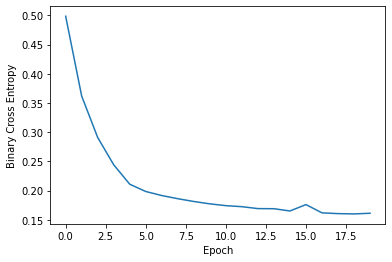

In [ ]:
plt.plot(lossHistory)
plt.xlabel("Epoch")
plt.ylabel("Binary Cross Entropy")
plt.show()

In [ ]:
predictions = model.predict_classes(x= testX, batch_size=64)
predictions = predictions[:, 0, 0]
showReport(testY, predictions)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP =  520017 			FP =  32352 

FN =  280137 			TN =  272373 

% of fraud detected:	 0.49 ( 0.4929738828256502 )

% of fraud missed:	 0.51 ( 0.5070261171743498 )

Average Precision-Recall score:	 0.6941813133469317


### Model 4
This model uses the structure from **Model 2** but has went through 10 epochs.

In [ ]:
# Balance the data by using SMOTE
oversample = SMOTE()
overX, overY = oversample.fit_resample(X, Y)

# Scale data
X_scaled = scaler.fit_transform(overX)

# Reshape X form 2d to 3d
newX = np.array(X_scaled)
newX = newX.reshape(newX.shape[0], newX.shape[1], 1)

# Split the data into 80% training and 20% testing, make sure data split is consistent (random_state)
trainX, testX, trainY, testY = train_test_split(newX, overY, test_size = 0.2, random_state = 5)

path = "/content/drive/My Drive/Colab Notebooks/Project/Data/Models/Scaled/More Epochs/Model 2/"

model = keras.models.load_model(path + "RNN_epochs_10_batch_64_LSTM.h5")
lossHistory = np.genfromtxt(path + "loss.csv", delimiter=',')

print(model.summary())

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 128)           66560     
_________________________________________________________________
dropout (Dropout)            (None, 10, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 64)            49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 32)            12416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 32)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 16)            3

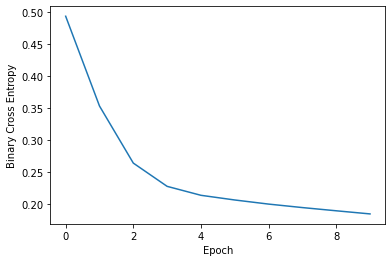

In [ ]:
plt.plot(lossHistory)
plt.xlabel("Epoch")
plt.ylabel("Binary Cross Entropy")
plt.show()

In [ ]:
predictions = model.predict_classes(x= testX, batch_size=64)
predictions = predictions[:, 0, 0]
showReport(testY, predictions)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP =  520000 			FP =  32369 

FN =  288752 			TN =  263758 

% of fraud detected:	 0.48 ( 0.4773814048614505 )

% of fraud missed:	 0.52 ( 0.5226185951385496 )

Average Precision-Recall score:	 0.6865425238102194


# Conclusion
Overall different models have been proposed - **Random Forest, XGBoost, Logistic Regression, K-Nearest Neighbour, Naive Bayes and Recurrent Neural Networks with SimpleRNN and LSTM cells**. The models produce different results. The main emphasis of this research was to minimize the **False Negative** transactions so financial losses can be further reduced. The **SMOTE** technique has been used to create synthetic fraudulent transactions because the initial dataset was highly unbalanced. Ideally to generate better models, we would require a balanced dataset with fraudulent and genuine transactions.

# Further research
- •	Create a custom loss function for Traditional Machine Learning and Deep Learning that calculates the amount lost based on False Negative transactions when a model misclassifies a transaction. This might be a challenge because PaySim is a mobile money simulator and real-life administrative costs that banks have also play a crucial part in calculating the total loss of a bank<br><br>
- •	Investigate and improve currently proposed Deep Learning models. Training takes a long time, and more experiments need to be ran with different epochs, batch sizes and create a new RNN model. In addition, RNN might not be the most suitable model for this dataset because RNN learns sequential data. A fraudulent transaction can also be caught before a request has even been made just by looking at the user's behaviour on the website, how long it takes them to go from one page to another and even how much time they spend filling up card information or staying on a website.